In [288]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm,trange
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import shutil
import skimage.exposure


### Sinomaly noise

In [343]:
torch.manual_seed(10)
device="cuda"

In [290]:
def synomaly_noise_like(x, anomaly_sigma=7, anomaly_threshold=150, anomaly_offset=0.5, anomaly_direction=1):
    """
    Generate Synomaly noise.

    :param x: input image
    :param synth_anomaly_masks: masks for synthetic noise regions
    :param mode: training (add synthetic anomalies) or inference (not add synthetic anomalies)
    :param anomaly_sigma: size of anomalies, the larger the sigma, the larger the anomalies, brats 3, ultrasound 7, lits 5
    :param anomaly_threshold: threshold for anomalies, the larger the threshold, the fewer anomalies, brats 175, ultrasound 150, lits 175
    :param anomaly_offset: offset for anomalies, the larger the offset, the brighter the anomalies, brats 0.5, ultrasound 0.5, lits 0.75
    :param anomaly_direction: direction of anomalies, 1 for brighter, -1 for darker, brats 1, ultrasound 1, lits -1
    :return: Synomaly noise
    """

    noise = torch.zeros(x.shape)
    height, width = x.shape

    # create Gaussian background noise
    background_noise = np.random.randn(height, width)
    blur = cv2.GaussianBlur(background_noise, (0, 0), sigmaX=anomaly_sigma, sigmaY=anomaly_sigma, borderType=cv2.BORDER_DEFAULT)
    stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0, 255))
    shape_mask = cv2.threshold(stretch, anomaly_threshold, 1, cv2.THRESH_BINARY)[1]
    combined = background_noise.copy()
    combined[shape_mask == 1] += anomaly_direction * (torch.rand(1).item() + anomaly_offset)  # add or reduce 0.0-1.0 plus offset
    noise= torch.from_numpy(combined)

    return noise.to(x.device)

In [366]:
def montrer(a):
    plt.imshow(a, cmap='gray')
    plt.axis('off')
    plt.show()

anomaly_sigma=5
anomaly_threshold=50
anomaly_offset=0.5
anomaly_direction=1
noise=np.random.randn(128,128)
blur=cv2.GaussianBlur(noise, (0, 0), sigmaX=anomaly_sigma, sigmaY=anomaly_sigma, borderType=cv2.BORDER_DEFAULT)
stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0, 255))
shape_mask = cv2.threshold(stretch, anomaly_threshold, 1, cv2.THRESH_BINARY)[1]
combined = noise.copy()
combined[shape_mask == 1] += anomaly_direction * (torch.rand(1).item() + anomaly_offset)  # add or reduce 0.0-1.0 plus offset

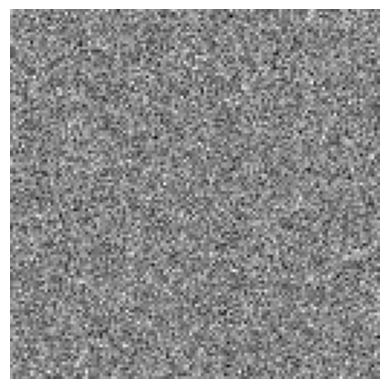

In [370]:
montrer(noise)

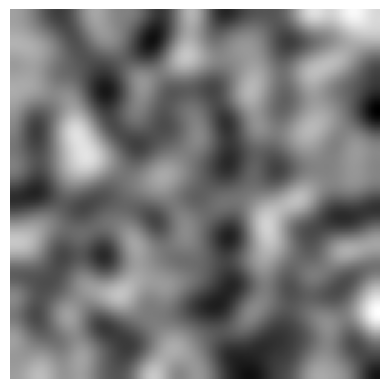

In [371]:
montrer(blur)

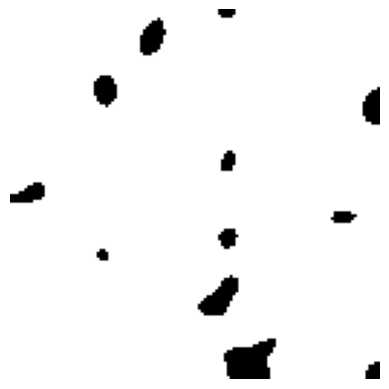

In [372]:
montrer(shape_mask)

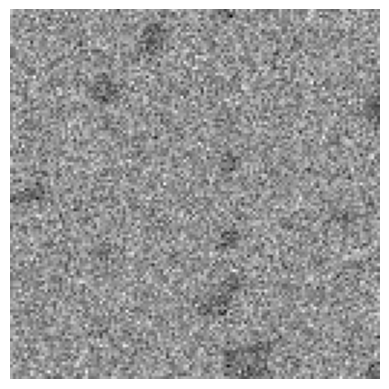

In [373]:
montrer(combined)

In [309]:
import torch
import numpy as np
import cv2
import skimage.exposure

def synomaly_noise_like(x, anomaly_sigma=7, anomaly_threshold=150, anomaly_offset=0.5, anomaly_direction=1):
    """
    Generate Synomaly noise.

    :param x: input image (PyTorch Tensor of shape N, C, H, W)
    :param anomaly_sigma: size of anomalies
    :param anomaly_threshold: threshold for anomalies
    :param anomaly_offset: offset for anomalies
    :param anomaly_direction: direction of anomalies, 1 for brighter, -1 for darker
    :return: Synomaly noise (PyTorch Tensor of shape N, C, H, W)
    """

    # Extraire les dimensions H et W (les deux dernières)
    # x.shape est de forme (N, C, H, W)
    height, width = x.shape[-2:]

    # Le bruit est généré par tranche (slice) pour chaque image du batch
    noise_batch = []

    # Nous itérons sur le batch (N) et les canaux (C) pour traiter chaque tranche 2D
    for img_slice in x.cpu().numpy().reshape(-1, height, width):

        # Le masque de Synomaly est souvent généré sur des données 2D
        background_noise = np.random.randn(height, width)

        # 1. Flou Gaussien (pour générer des formes douces)
        # La sortie est en float (non [0, 255])
        blur = cv2.GaussianBlur(background_noise, (0, 0), sigmaX=anomaly_sigma, sigmaY=anomaly_sigma, borderType=cv2.BORDER_DEFAULT)

        # 2. Rescale (pour le seuillage)
        # Rescale pour que le seuil de 0 à 255 puisse être appliqué (même si les données sont float)
        # Nous utilisons la plage 'image' pour rescale la distribution du flou.
        stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0, 255))

        # 3. Seuillage Binaire (création de la forme)
        # shape_mask est de 0 ou 1
        _, shape_mask = cv2.threshold(stretch.astype(np.uint8), anomaly_threshold, 1, cv2.THRESH_BINARY)

        # 4. Combinaison du bruit de fond et de l'anomalie
        combined_noise = background_noise.copy()

        # Ajout/Réduction d'une valeur constante (offset + aléatoire) dans la région masquée
        anomaly_magnitude = anomaly_direction * (torch.rand(1).item() + anomaly_offset)

        # Application de l'anomalie
        combined_noise[shape_mask == 1] += anomaly_magnitude

        noise_batch.append(combined_noise)

    # Reconvertir en tenseur PyTorch et restaurer la forme (N, C, H, W)
    noise = torch.from_numpy(np.array(noise_batch, dtype=np.float32)).to(x.device)

    # Si le format est (N*C, H, W), nous devons le remodeler en (N, C, H, W)
    noise = noise.view(x.shape)

    return noise

spectral density

In [300]:
def synomaly_noise_random_like(img,sigma=7,d=1):
    tau=25+40*random.random()
    return synomaly_noise_like(img,anomaly_sigma=sigma, anomaly_threshold=tau, anomaly_offset=0.9, anomaly_direction=d)

(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

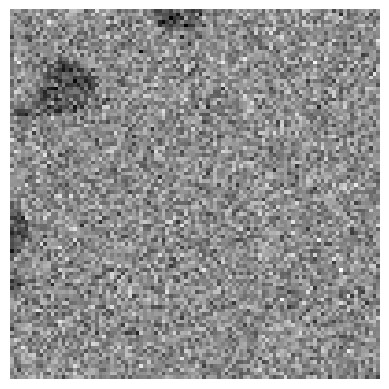

In [301]:
plt.imshow(synomaly_noise_random_like(torch.zeros(100,100),sigma=7),cmap='gray')
plt.axis("off")

Run the previous cell a few times to see that the spots size change

# Difusion model

In [302]:
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import random

# Initialisation des graines pour la reproductibilité (doit correspondre à l'entraînement)
random.seed(314)
np.random.seed(314)
torch.manual_seed(314)

# --- CLASSES DE DATASET NÉCESSAIRES (SIMULATION DE data_loader.py) ---

class RescaleToMinusOneToOne:
    """Normalise les images dans la plage [-1, 1], nécessaire pour les modèles de diffusion."""
    def __call__(self, img):
        # Assurez-vous que l'entrée est toujours un tenseur PyTorch
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img, dtype=torch.float32)

        # Normalisation standard de Min-Max: 2 * (x - min) / (max - min) - 1
        min_val = img.min()
        max_val = img.max()

        # Éviter la division par zéro si l'image est uniforme (rare mais possible)
        if max_val == min_val:
            return torch.zeros_like(img)

        return 2 * (img - min_val) / (max_val - min_val) - 1

class CustomLitsDataset(Dataset):
    """
    Dataset pour charger les tranches LiTS prétraitées (images ou masques).
    Applique les transformations nécessaires (resize, ToTensor, normalisation).
    """
    def __init__(self, data_array, resized_size=128, augment=True, is_mask=False):
        # data_array est censé être un numpy array de tranches [N, H, W]
        self.data = [torch.from_numpy(arr).float() for arr in data_array]
        self.resized_size = resized_size

        # Définition des transformations
        transforms_list = [
            torchvision.transforms.ToPILImage(mode="F"),
            torchvision.transforms.Resize((self.resized_size, self.resized_size)),
            torchvision.transforms.ToTensor()
        ]

        if augment:
            # Ajouter les augmentations pour les images (pas pour les masques)
            transforms_list.insert(1, torchvision.transforms.RandomHorizontalFlip(p=0.5))
            transforms_list.insert(2, torchvision.transforms.RandomVerticalFlip(p=0.5))

        if not is_mask:
            # Normalisation finale pour le DDPM sur les images (pas sur les masques)
            transforms_list.append(RescaleToMinusOneToOne())

        self.transform = torchvision.transforms.Compose(transforms_list)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index].unsqueeze(0) # Ajoute la dimension du canal (C, H, W)
        transformed_sample = self.transform(sample)
        return transformed_sample


# --- NOUVELLE FONCTION get_training_dataloaders ---

def get_training_dataloaders(image_file_path: str, mask_file_path: str, batch_size: int, img_size: int, augment: bool = True):
    """
    Charge les données d'entraînement (images et masques) depuis des fichiers PKL
    et retourne les DataLoaders correspondants.

    :param image_file_path: Chemin du fichier PKL contenant les images saines (healthy abdomen).
    :param mask_file_path: Chemin du fichier PKL contenant les masques de foie correspondants.
    :param batch_size: Taille du lot pour l'entraînement.
    :param img_size: Taille cible pour le redimensionnement (e.g., 128).
    :param augment: Appliquer ou non l'augmentation des données.
    :return: Tuple (dataloader_images, dataloader_masks)
    """

    print("Chargement des données d'entraînement...")

    try:
        # Charger les images (Fichier 1: train_healthy_abdomen_dataset.pkl)
        with open(image_file_path, "rb") as f:
            train_images_data = pickle.load(f)

        # Charger les masques (Fichier 2: train_healthy_liver_masks.pkl)
        with open(mask_file_path, "rb") as f:
            train_masks_data = pickle.load(f)

    except FileNotFoundError as e:
        print(f"Erreur: Fichier PKL non trouvé. Veuillez vérifier le chemin: {e.filename}")
        return None, None
    except Exception as e:
        print(f"Erreur lors du chargement des fichiers PKL: {e}")
        return None, None

    # Conversion en numpy array pour s'assurer du bon format
    train_images_data = np.array(train_images_data, dtype=np.float32)
    train_masks_data = np.array(train_masks_data, dtype=np.uint8)

    # Création des Datasets
    image_dataset = CustomLitsDataset(
        data_array=train_images_data,
        resized_size=img_size,
        augment=augment,
        is_mask=False
    )
    mask_dataset = CustomLitsDataset(
        data_array=train_masks_data,
        resized_size=img_size,
        augment=augment,
        is_mask=True
    )

    # Création des DataLoaders
    # IMPORTANT: Le générateur est utilisé pour s'assurer que les images et les masques
    # sont brassés (shuffled) EXACTEMENT de la même manière s'ils sont chargés dans deux DataLoaders.
    generator = torch.Generator().manual_seed(314)

    dataloader_images = DataLoader(
        image_dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=generator
    )
    dataloader_masks = DataLoader(
        mask_dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=generator
    )

    print(f"Chargement réussi. Total de {len(train_images_data)} tranches d'entraînement.")
    print(f"Les DataLoaders sont prêts (Batch size: {batch_size}, Image size: {img_size}).")

    return dataloader_images, dataloader_masks

In [319]:
from unet import UNetModel
from data_loader import get_training_data #


class SimpleDiffusion:
    def __init__(self, noise_steps=500, device="cuda"):
        self.noise_steps = noise_steps
        self.device = device

        # 1. Définir le "Schedule" (Planning de bruit)
        # On utilise un schedule linéaire standard (comme dans get_beta_schedule("linear"))
        beta_start = 0.0001
        beta_end = 0.02
        self.betas = torch.linspace(beta_start, beta_end, noise_steps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0) # Produit cumulatif

    def noise_images(self, x, t, noise_type='gauss'):
        """
        Ajoute du bruit gaussien pur à l'image x au temps t.
        Formule: x_t = sqrt(alpha_hat)*x_0 + sqrt(1-alpha_hat)*epsilon
        """
        # Assure un bon dimensionnement pour le broadcast
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        if noise_type == 'gauss':
            # Génération du bruit blanc Gaussien (epsilon)
            epsilon = torch.randn_like(x)
        if noise_type == 'synomaly_random':
            epsilon = synomaly_noise_random_like(x)
        if noise_type == "synomaly":
            epsilon = synomaly_noise_like(x)

        # Image bruitée: x_t = sqrt(alpha_hat)*x_0 + sqrt(1-alpha_hat)*epsilon
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        """Sélectionne des pas de temps aléatoires pour le batch"""
        # Commence à 1 car t=0 n'est pas utilisé dans le processus forward
        return torch.randint(low=1, high=self.noise_steps, size=(n,), device=self.device)

TRAIN_PATH=r"C:\Users\danku\Documents\Уроки\ENS\3A\MVA\S1\Medical imaging\Code_medical_image_analysis\Synomaly-main\Synomaly-main\output\LiTS\train_healthy_abdomen_dataset.pkl"
TRAIN_MASKS_PATH=r"C:\Users\danku\Documents\Уроки\ENS\3A\MVA\S1\Medical imaging\Code_medical_image_analysis\Synomaly-main\Synomaly-main\output\LiTS\train_healthy_liver_masks.pkl"

def train_simple_ddpm_full_unet(ARGS):
    print(f"Lancement de l'entraînement sur {ARGS['device']} (Batch size: {ARGS['batch_size']}, Img size: {ARGS['img_size']})...")

    # 1. Préparation des données
    dataloader, _ = get_training_dataloaders(TRAIN_PATH,TRAIN_MASKS_PATH,ARGS["batch_size"],ARGS['img_size'])

    # 2. Initialisation du modèle
    model = UNetModel(
        image_size=ARGS['img_size'],
        in_channels=ARGS['in_channels'],
        model_channels=ARGS['model_channels'],
        out_channels=ARGS['out_channels'],
        num_res_blocks=ARGS['num_res_blocks'],
        attention_resolutions=ARGS['attention_resolutions'],
        dropout=ARGS['dropout'],
        channel_mult=ARGS['channel_mult'],
        num_heads=ARGS['num_heads'],
        num_head_channels=ARGS['num_head_channels'],
    ).to(ARGS['device'])

    print(f"Nombre de paramètres du modèle: {sum(p.numel() for p in model.parameters())}")

    diffusion = SimpleDiffusion(noise_steps=500, device=ARGS['device'])
    optimizer = optim.AdamW(model.parameters(), lr=ARGS['lr'])
    mse = nn.MSELoss()

    # 3. Boucle d'entraînement
    list_of_losses = []
    for epoch in range(ARGS['epochs']):
        print(f"\nEpoch {epoch+1}/{ARGS['epochs']}")
        pbar = tqdm(dataloader)
        epoch_loss = []

        for i, images in enumerate(pbar):
            images = images.to(ARGS['device'])

            # A. Sample t et B. Ajout de bruit
            t = diffusion.sample_timesteps(images.shape[0])
            x_t, noise = diffusion.noise_images(images, t,ARGS['noise_type'])

            # C. Prédiction du bruit
            predicted_noise = model(x_t, t)

            # D. Calcul MSE
            loss = mse(noise, predicted_noise)

            # E. Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            pbar.set_postfix(MSE=loss.item())

        avg_loss = sum(epoch_loss) / len(epoch_loss)
        list_of_losses.append(avg_loss)

    return model

In [304]:
def save_model(model, path: str):
    """
    Save a PyTorch model (state_dict) to a safe path.
    Automatically adds .pth if the file extension is missing.

    model : nn.Module
    path  : string like "checkpoint/unet", "unet.pth", "models/u1"
    """

    # Auto-add .pth extension if there is no extension
    if not os.path.splitext(path)[1]:
        path = path + ".pth"

    # Create directory only if it exists in path
    folder = os.path.dirname(path)
    if folder != "":
        os.makedirs(folder, exist_ok=True)

    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [305]:
def load_model(model_class, path: str, *model_args, **model_kwargs):
    model = model_class(*model_args, **model_kwargs)

    state = torch.load(path, map_location="cpu", weights_only=True)
    model.load_state_dict(state)

    model.eval()
    return model


##### Inference

In [306]:
import torch
import numpy as np
import pickle
import os
import cv2
import time
from scipy.ndimage import label
from sklearn.metrics import precision_recall_curve, auc
import warnings
from skimage.metrics import structural_similarity as ssim
import math

# --- IMPORTS DE VOTRE PROJET (DOIVENT ÊTRE VALIDES) ---
from unet import UNetModel
# Supprimé: from gaussian_diffusion import GaussianDiffusionModel
import data_loader
# Supprimé: from helpers import get_args_from_json


# --- FONCTIONS UTILITAIRES DE DÉTECTION ET D'ÉVALUATION ---

def get_dice_score(diff_truth, diff_pred):
    """Calcule le Dice Score (DSC) entre la vérité terrain binaire et la prédiction binaire."""
    if diff_truth.sum() == 0 and diff_pred.sum() == 0:
        return 1.0
    dice_score = 2 * (diff_truth & diff_pred).sum() / (diff_truth.sum() + diff_pred.sum())
    return round(dice_score, 4)

def remove_small_spots(map_array, threshold=30):
    """Supprime les petites composantes connexes dans la carte d'anomalie."""
    binary_map = map_array > 0
    labeled_map, num_features = label(binary_map)
    component_sizes = np.bincount(labeled_map.ravel())
    large_components_masked = component_sizes[labeled_map] >= threshold
    return large_components_masked * map_array

def create_gaussian_blur_difference_map(x_0, x_pred, kernel_size=3, threshold=0.25):
    """Calcule la carte de différence après flou Gaussien et application du seuil."""
    x_0_array = x_0.cpu().squeeze().numpy()
    x_0_blurred = cv2.GaussianBlur(x_0_array, (kernel_size, kernel_size), 0)

    x_pred_array = x_pred.cpu().detach().numpy().squeeze()
    x_pred_blurred = cv2.GaussianBlur(x_pred_array, (kernel_size, kernel_size), 0)

    diff = np.abs(x_0_blurred - x_pred_blurred)

    diff[diff < threshold] = 0

    # NOTE: Le seuil de remove_small_spots est ici fixé à 50. Ajustez-le au besoin.
    diff_final = remove_small_spots(diff, threshold=50)

    return diff_final


# --- FONCTION PRINCIPALE D'INFÉRENCE MONO-STAGE (MISE À JOUR) ---

def run_single_stage_inference(
    model: torch.nn.Module,
    diffusion_obj: torch.nn.Module,
    test_data_path: str,
    mask_data_path: str,
    inference_noise_steps: int,
    gaussian_blur_kernel_size: int,
    anomaly_threshold: float,
    img_size: int,
    num_test_img: int,
    device: str = 'cuda'
) -> dict:
    """
    Exécute l'inférence mono-stage et calcule le Dice Score moyen en utilisant
    la logique de bruitage de SimpleDiffusion et les imports de data_loader.
    """

    print("--- DÉMARRAGE DE L'INFÉRENCE ---")

    # 1. PRÉPARATION DES ARGUMENTS POUR data_loader.get_test_data

    # CORRECTION DU CHEMIN: Nous déterminons le répertoire parent (dossier 'LiTS')
    # pour le output_path, qui est le format attendu par data_loader.py
    output_base_path = os.path.dirname(test_data_path)

    # La logique de data_loader.py est complexe. Nous devons simuler la structure
    # attendue par data_loader.get_test_data pour qu'il puisse charger les bonnes données.
    args_simule = {
        'dataset': 'lits',
        'mode': 'anomalous',
        'num_test_img': num_test_img,
        'img_size': img_size,
        # Ce chemin est maintenant C:\Users\danku\...\Synomaly-main\Synomaly-main\output\LiTS
        'output_path': output_base_path,
        'Version': 'old'
    }

    # 2. Chargement des données de test LiTS via data_loader.py
    test_dataset_loader, groundtruth_anomaly_masks = data_loader.get_test_data(args_simule)


    model.to(device)
    model.eval()
    dice_score_list = []
    start_time = time.time()

    # Accès aux paramètres alpha_hat de la diffusion (SimpleDiffusion)
    try:
        alpha_hat = diffusion_obj.alpha_hat
    except AttributeError:
        # Affiche un message d'erreur clair pour l'utilisateur
        raise AttributeError(
            "L'objet de diffusion ('diffusion_obj') n'a pas d'attribut 'alpha_hat'. "
            "Veuillez vous assurer qu'il s'agit d'une instance de la classe SimpleDiffusion "
            "et non de la classe elle-même, et que l'initialisation de SimpleDiffusion s'est bien déroulée."
        )

    for i, image in enumerate(test_dataset_loader):
        x_0 = image.to(device)

        with torch.no_grad():
            # Inférence Mono-stage
            t_int = inference_noise_steps

            # CORRECTION: S'assurer que le tenseur de temps est de type torch.long
            t = torch.tensor([t_int], device=x_0.device, dtype=torch.long).repeat(x_0.shape[0])

            # 1. BRUITAGE: Utilisation de la logique de SimpleDiffusion pour obtenir x_t
            x_t, _ = diffusion_obj.noise_images(x_0, t)

            # 2. PRÉDICTION: L'U-Net prédit le bruit (epsilon_theta)
            predicted_noise = model(x_t, t)

            # 3. RECONSTRUCTION (Formule p_sample simplifiée pour la prédiction x_0)

            # Index du temps (t_int - 1 car les pas de temps vont de 1 à T)
            # Vérifiez que t_int est dans la plage valide [1, noise_steps]
            if t_int <= 0 or t_int > diffusion_obj.noise_steps:
                raise ValueError(f"Le pas de temps d'inférence (t={t_int}) est hors de la plage valide [1, {diffusion_obj.noise_steps}].")

            time_index = t_int - 1

            # Paramètres du pas de temps t
            alpha_hat_t_scalar = alpha_hat[time_index]

            # CORRECTION DE L'ERREUR D'INDEXATION (too many indices):
            # 1. Obtenir les valeurs scalaires
            # Utilisation de .to(x_0.dtype) pour assurer la cohérence du type (float32 vs float64)
            sqrt_alpha_hat_t = torch.sqrt(alpha_hat_t_scalar).to(x_0.dtype)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1.0 - alpha_hat_t_scalar).to(x_0.dtype)

            # 2. Étendre les valeurs scalaires au format (Batch, C, H, W) pour l'opération
            # Utilisation de .view(1, 1, 1, 1) pour créer les dimensions de broadcasting, puis expand_as
            sqrt_alpha_hat_t = sqrt_alpha_hat_t.view(1, 1, 1, 1).expand_as(x_0)
            sqrt_one_minus_alpha_hat_t = sqrt_one_minus_alpha_hat_t.view(1, 1, 1, 1).expand_as(x_0)

            # Formule: x_pred = (x_t - sqrt(1 - alpha_hat_t) * predicted_noise) / sqrt(alpha_hat_t)
            # C'est la formule pour estimer x_0 à partir de x_t et de l'estimation du bruit.
            x_pred = (x_t - sqrt_one_minus_alpha_hat_t * predicted_noise) / sqrt_alpha_hat_t


        # Création de la carte d'anomalie
        difference_map = create_gaussian_blur_difference_map(
            x_0, x_pred,
            kernel_size=gaussian_blur_kernel_size,
            threshold=anomaly_threshold
        )

        # Binarisation et calcul du Dice Score
        groundtruth_mask_set = groundtruth_anomaly_masks[i]

        # Le MaskSet retourne un array numpy qu'il faut binariser
        groundtruth_anomaly = groundtruth_mask_set.astype(bool)
        predicted_anomaly = (difference_map > 0).astype(bool)

        dice_score = get_dice_score(groundtruth_anomaly, predicted_anomaly)
        dice_score_list.append(dice_score)

    # Calcul des moyennes
    if not dice_score_list:
        print("Aucune donnée testée.")
        return {}

    mean_dice_score = round(np.mean(dice_score_list), 4)

    print(f"Inférence terminée en {time.time() - start_time:.2f} secondes.")
    print("--------------------------------------------------")
    print(f"Résultat Final (t={inference_noise_steps}, K={gaussian_blur_kernel_size}, T={anomaly_threshold}) :")
    print(f"Dice Score Moyen: {mean_dice_score}")
    print("--------------------------------------------------")

    return {"dice_score_mean": mean_dice_score}

# Experimental part

In [375]:
LITS_OUTPUT_DIR = r"C:\Users\danku\Documents\Уроки\ENS\3A\MVA\S1\Medical imaging\Code_medical_image_analysis\Synomaly-main\Synomaly-main\output\LiTS"
ARGS = {
        "dataset": "lits",
        "output_path": "LITS_OUTPUT_DIR",
        "json_file_name": "args_simple_gaussian", # Nom pour les checkpoints
        "img_size": 128,
        "batch_size": 4, # Réduit pour la stabilité
        "num_training_data": 5000,
        "epochs": 1,
        "lr": 1e-4,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "apply_mask": False,
        "noise_type": "synomaly",

        # Paramètres UNet allégés.
        "in_channels": 1,
        "model_channels": 64,
        "out_channels": 1,
        "num_res_blocks": 2,
        "attention_resolutions": "32,16",
        "dropout": 0.0,
        "channel_mult": "1,2,3,4",
        "num_heads": 2,
        "num_head_channels": 64,
    }

In [ ]:
model=train_simple_ddpm_full_unet(ARGS)

Lancement de l'entraînement sur cuda (Batch size: 4, Img size: 128)...
Chargement des données d'entraînement...
Chargement réussi. Total de 7200 tranches d'entraînement.
Les DataLoaders sont prêts (Batch size: 4, Image size: 128).
Nombre de paramètres du modèle: 21853249

Epoch 1/1


 17%|█▋        | 298/1800 [00:38<03:06,  8.06it/s, MSE=0.027] 

In [342]:
# --- 1. DÉFINITION DES CHEMINS ET HYPERPARAMÈTRES (À ADAPTER) ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Vos chemins absolus vers les fichiers PKL
TEST_DATA_PATH = r'C:\Users\danku\Documents\Уроки\ENS\3A\MVA\S1\Medical imaging\Code_medical_image_analysis\Synomaly-main\Synomaly-main\output\LiTS\test_anomalous_abdomen_dataset.pkl'
MASK_DATA_PATH = r'C:\Users\danku\Documents\Уроки\ENS\3A\MVA\S1\Medical imaging\Code_medical_image_analysis\Synomaly-main\Synomaly-main\output\LiTS\test_anomalous_tumor_masks.pkl'

INFERENCE_T = 200      # Pas de temps t (t_int dans le code)
GAUSSIAN_K = 7         # Taille du noyau de flou (Kernel Size)
ANOMALY_TAU = 0.25     # Seuil de l'anomalie (Threshold)
IMG_SIZE = 128         # Taille de l'image (doit correspondre à l'entraînement)
NUM_TEST = 1000         # Nombre d'images à tester

# --- 2. EXÉCUTION DE LA FONCTION ---
# Assurez-vous que 'model' (UNet) et 'diffusion' (SimpleDiffusion)
# sont déjà définis.

resultats_dice = run_single_stage_inference(
    model=model,
    diffusion_obj=SimpleDiffusion(),
    test_data_path=TEST_DATA_PATH,
    mask_data_path=MASK_DATA_PATH,
    inference_noise_steps=INFERENCE_T,
    gaussian_blur_kernel_size=GAUSSIAN_K,
    anomaly_threshold=ANOMALY_TAU,
    img_size=IMG_SIZE,
    num_test_img=NUM_TEST,
    device=DEVICE
)

print(f"Dice Score Moyen obtenu : {resultats_dice['dice_score_mean']}")

--- DÉMARRAGE DE L'INFÉRENCE ---
Testing on 1000 randomly selected images. Mode: anomalous
Inférence terminée en 19.89 secondes.
--------------------------------------------------
Résultat Final (t=200, K=7, T=0.25) :
Dice Score Moyen: 0.0516
--------------------------------------------------
Dice Score Moyen obtenu : 0.0516


In [329]:
path=r"my_models\model2"

In [330]:
save_model(model2,path)

Model saved to my_models\model2.pth


In [237]:
model_bis= load_model(
    UNetModel,
    path,
    image_size=ARGS['img_size'],
    in_channels=ARGS['in_channels'],
    model_channels=ARGS['model_channels'],
    out_channels=ARGS['out_channels'],
    num_res_blocks=ARGS['num_res_blocks'],
    attention_resolutions=ARGS['attention_resolutions'],
    dropout=ARGS['dropout'],
    channel_mult=ARGS['channel_mult'],
    num_heads=ARGS['num_heads'],
    num_head_channels=ARGS['num_head_channels'],
)
model_bis=model_bis.to(device)


In [239]:
def same_weights(m1, m2):
    for (k1, v1), (k2, v2) in zip(m1.state_dict().items(), m2.state_dict().items()):
        if k1 != k2:
            return False
        if not torch.equal(v1, v2):
            return False
    return True
same_weights(model_bis,model)

True

In [5]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import os

# 1. Définir les chemins de base (similaire à helpers.py)
# Assurez-vous que ce chemin est correct pour votre environnement local
OUTPUT_PATH = "../output/LiTS"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 128 # Taille de l'image après redimensionnement (dans data_loader)

# --- Paramètres de Test factices pour LiTS ---
# Ces paramètres sont nécessaires pour initialiser le data_loader
ARGS = {
    "dataset": "lits",
    "output_path": OUTPUT_PATH,
    "mode": "anomalous", # On charge les images anomales pour l'exemple
    "num_test_img": 1,   # On ne chargera qu'une seule image au hasard
    "img_size": IMG_SIZE,
    "Version": "old"
}

def load_random_lits_image():
    """Charge une image aléatoire du jeu de données de test LiTS."""

    # Étape A: Charger les données brutes (listes d'arrays NumPy)
    # Le chemin pointe vers le jeu de données anomales LiTS
    try:
        with open(f"{OUTPUT_PATH}/test_anomalous_abdomen_dataset.pkl", "rb") as f:
            data = pickle.load(f)
        print(f"Dataset chargé. Nombre total d'images: {len(data)}")
    except FileNotFoundError:
        print(f"Erreur : Le fichier de données LiTS n'a pas été trouvé à {OUTPUT_PATH}/test_anomalous_abdomen_dataset.pkl.")
        return

    # Étape B: Sélectionner un index aléatoire
    random_index = random.randint(0, len(data) - 1)

    # Étape C: Créer une DataLoader juste pour cette image (ou utiliser l'array NumPy direct)
    # Dans ce cas, on utilise l'array NumPy directement
    image_array = data[random_index]
    print(image_array.shape)
    # Étape D: Simuler les transformations de data_loader.py (Redimensionnement, RescaleToMinusOneToOne)
    # Il est plus simple d'utiliser directement la fonction get_test_data_ (même si elle nécessite un refactoring)

    # --- Si vous utilisez le data_loader.py fourni ---

    # Pour utiliser les transformations exactes du data_loader, on va importer et appeler sa logique.
    from data_loader import UltrasoundDataset, DataLoader # On utilise UltrasoundDataset car il est utilisé pour LiTS

    # 1. Créer le dataset (applique les transformations)
    dataset = UltrasoundDataset([image_array], IMG_SIZE, augment=False)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # 2. Extraire le tenseur transformé
    transformed_image = next(iter(dataloader)).to(DEVICE)
    """
    # 3. Afficher l'image (dénormalisée pour la visualisation)
    # L'image est dans la plage [-1, 1], nous la ramenons à [0, 1] pour matplotlib
    image_to_plot = (transformed_image.cpu().squeeze().numpy() + 1) / 2

    plt.figure(figsize=(6, 6))
    plt.imshow(image_to_plot, cmap='gray')
    plt.title(f"Image LiTS anomale (index {random_index}) - {IMG_SIZE}x{IMG_SIZE}")
    plt.axis('off')
    plt.show()"""
    return transformed_image

# Exécuter la fonction
image=load_random_lits_image()

Dataset chargé. Nombre total d'images: 1000
(512, 512)


In [15]:
def afficher_une_image(img,title=""):
    image_to_plot = (img.cpu().squeeze().detach().numpy() + 1) / 2
    n,m=image_to_plot.shape
    plt.figure(figsize=(6, 6))
    plt.imshow(image_to_plot, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [16]:
model.eval()
t = torch.tensor([10]).to(image.device)
a=model(image,t)
a.shape

torch.Size([1, 1, 128, 128])

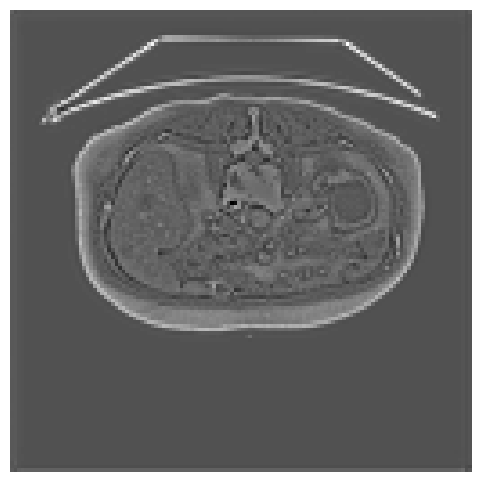

In [17]:
afficher_une_image(a)

In [71]:
ε=sinomaly_noise_like(torch.tensor(np.zeros((128,128))),0.16)

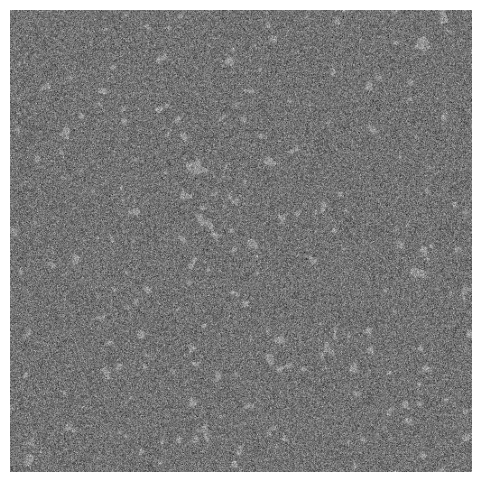

In [12]:
afficher_une_image(ε)

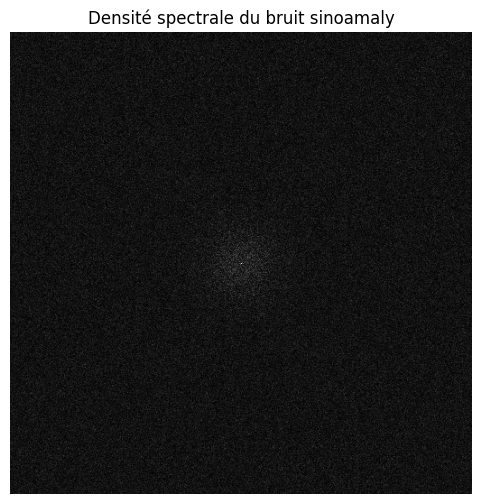

In [13]:
afficher_une_image(torch.fft.fftshift(torch.abs(torch.fft.fft2(ε))),title="Densité spectrale du bruit sinoamaly")

In [14]:
afficher_une_image(b)

NameError: name 'b' is not defined

In [6]:
torch.min(b)

NameError: name 'b' is not defined